# Fraud Audit
    a.	Preprocess and clean if necessary.
    b.	Build a model predicting “Risk”. 
    c.	Remember to comment your code and give rationales for models, algorithms, and approaches. 


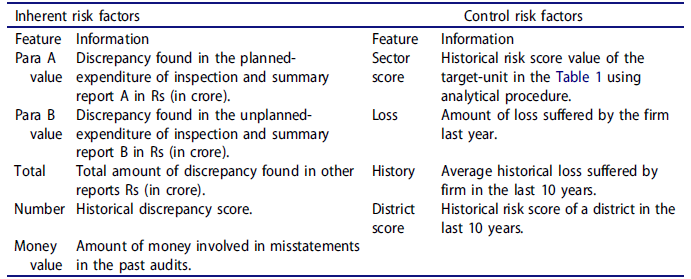

## Import Packages

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
# %matplotlib inline

## Load data

import pyodbc
import urllib
import sqlalchemy

'''connect to datahub'''

params_datahub = urllib.parse.quote_plus("DRIVER={SQL Server Native Client 11.0};"
                                 "SERVER=localhost\SQLEXPRESS;"
                                 "DATABASE=datahub;"
                                 "UID=sa;"
                                 "PWD=user1")

engine_datahub = sqlalchemy.create_engine("mssql+pyodbc:///?odbc_connect={}".format(params_datahub))

df=pd.read_sql_table(r"audit_fraud_risk_data",engine_datahub)
df.head()

,Sector_score,LOCATION_ID,PARA_A,PARA_B,numbers,Money_Value,District_Loss,History,Score,Risk
0,3.89,23,4.18,2.50,5.0,3.38,2,0,2.4,1
1,3.89,6,0.00,4.83,5.0,0.94,2,0,2.0,0
2,3.89,6,0.51,0.23,5.0,0.00,2,0,2.0,0
3,3.89,6,0.00,10.80,6.0,11.75,2,0,4.4,1
4,3.89,6,0.00,0.08,5.0,0.00,2,0,2.0,0


<AxesSubplot:>

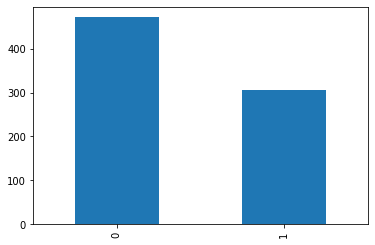

In [2]:
df.Risk.value_counts().plot(kind='bar')

## Data processing and cleaning

In [3]:
#check for missing values
df[df.isnull().any(axis=1)]

#replace mnissing value with median, a better representation of the center of the data if it's not normally ditributed
from sklearn.impute import SimpleImputer
imputer = SimpleImputer(missing_values=np.nan, strategy='median')
df['Money_Value']=imputer.fit_transform(df['Money_Value'].values.reshape(-1, 1))

#check if there is any missing values again
df[df.isnull().any(axis=1)]

#Process the only categorical attribute
df.LOCATION_ID.unique()

#convert to numbers. This way the text values will be converted to null.
df.LOCATION_ID=pd.to_numeric(df.LOCATION_ID, errors='coerce')

#replace null with mode 
imputer = SimpleImputer(missing_values=np.nan, strategy='most_frequent')
df.LOCATION_ID=imputer.fit_transform(df.LOCATION_ID.values.reshape(-1, 1))

#binning the numbers into 6 bins. 
bins = [-999,0, 9, 19, 29, 39, 49]
labels = [-1,0,1,2,3,4]
df['LOCATION_ID_binned'] = pd.cut(df['LOCATION_ID'], bins=bins, labels=labels).astype('int')
df=df.drop('LOCATION_ID',axis=1)
df.head()

#encode the attribute
def one_hot(df, cols):
    """
    @param df pandas DataFrame
    @param cols a list of columns to encode 
    @return a DataFrame with one-hot encoding
    """
    for each in cols:
        dummies = pd.get_dummies(df[each], prefix=each, drop_first=False)
        df = pd.concat([df, dummies], axis=1)
        df = df.drop([each], axis=1)
    return df
df=one_hot(df,['LOCATION_ID_binned'])
df.head()

,Sector_score,PARA_A,PARA_B,numbers,Money_Value,District_Loss,History,Score,Risk,LOCATION_ID_binned_0,LOCATION_ID_binned_1,LOCATION_ID_binned_2,LOCATION_ID_binned_3,LOCATION_ID_binned_4
0,3.89,4.18,2.50,5.0,3.38,2,0,2.4,1,0,0,1,0,0
1,3.89,0.00,4.83,5.0,0.94,2,0,2.0,0,1,0,0,0,0
2,3.89,0.51,0.23,5.0,0.00,2,0,2.0,0,1,0,0,0,0
3,3.89,0.00,10.80,6.0,11.75,2,0,4.4,1,1,0,0,0,0
4,3.89,0.00,0.08,5.0,0.00,2,0,2.0,0,1,0,0,0,0


## Create the function to train the model, test it, and visualize the results

In [4]:
def prediction(algorithm, training_x, testing_x, training_y, testing_y, cf, threshold_plot):
    #model
    algorithm.fit(training_x, training_y)
    predictions = algorithm.predict(testing_x)
    probabilities = algorithm.predict_proba(testing_x)
        
    print('Algorithm:', type(algorithm).__name__)
    print("\nClassification report:\n", classification_report(testing_y, predictions))
    print("Accuracy Score:", accuracy_score(testing_y, predictions))
    
    #confusion matrix
    conf_matrix = confusion_matrix(testing_y, predictions)
    #roc_auc_score
    model_roc_auc = roc_auc_score(testing_y, predictions) 
    print("Area under curve:", model_roc_auc,"\n")
    
    fpr, tpr, thresholds = roc_curve(testing_y, probabilities[:,1])
     
    #plot confusion matrix
    trace1 = go.Heatmap(z = conf_matrix,
                        x = ["Risk 0", "Risk 1"],
                        y = ["Risk 0", "Risk 1"],
                        showscale = False, colorscale = "Picnic",
                        name = "Confusion matrix")
    
    #plot roc curve
    trace2 = go.Scatter(x = fpr, y = tpr,
                        name = "Roc: " + str(model_roc_auc),
                        line = dict(color = ('rgb(22, 96, 167)'), width = 2))
    trace3 = go.Scatter(x = [0,1], y = [0,1],
                        line = dict(color = ('rgb(205, 12, 24)'), width = 2,
                        dash = 'dot'))
    
    if cf in ['coefficients', 'features']:
        if cf == 'coefficients':
            coefficients = pd.DataFrame(algorithm.coef_.ravel())
        elif cf == 'features':
            coefficients = pd.DataFrame(algorithm.feature_importances_)
        
        column_df = pd.DataFrame(training_x.columns.tolist())
        coef_sumry = (pd.merge(coefficients, column_df, left_index=True, 
                               right_index=True, how="left"))
        coef_sumry.columns = ["coefficients", "features"]
        coef_sumry = coef_sumry.sort_values(by = "coefficients", ascending=False)
        
        #plot coeffs
        trace4 = go.Bar(x = coef_sumry["features"], y = coef_sumry["coefficients"], 
                        name = "coefficients",
                        marker = dict(color = coef_sumry["coefficients"],
                                      colorscale = "Picnic",
                                      line = dict(width = .6, color = "black")
                                     )
                       )
        #subplots
        fig = make_subplots(rows=2, cols=2, specs=[[{}, {}], [{'colspan': 2}, None]],
                                subplot_titles=('Confusion matrix',
                                                'Receiver operating characteristic',
                                                'Feature importances')
                           )  
        fig.append_trace(trace1,1,1)
        fig.append_trace(trace2,1,2)
        fig.append_trace(trace3,1,2)
        fig.append_trace(trace4,2,1)
        fig['layout'].update(showlegend=False, title="Model performance",
                             autosize=False, height = 900, width = 800,
                             plot_bgcolor = 'rgba(240,240,240, 0.95)',
                             paper_bgcolor = 'rgba(240,240,240, 0.95)',
                             margin = dict(b = 195))
        fig["layout"]["xaxis2"].update(dict(title = "false positive rate"))
        fig["layout"]["yaxis2"].update(dict(title = "true positive rate"))
        fig["layout"]["xaxis3"].update(dict(showgrid = True, tickfont = dict(size = 10), tickangle = 90))
        
    elif cf == 'None':
        #subplots
        fig = make_subplots(rows=1, cols=2,
                            subplot_titles=('Confusion matrix',
                                            'Receiver operating characteristic')
                           )
        fig.append_trace(trace1,1,1)
        fig.append_trace(trace2,1,2)
        fig.append_trace(trace3,1,2)
        fig['layout'].update(showlegend=False, title="Model performance",
                         autosize=False, height = 500, width = 800,
                         plot_bgcolor = 'rgba(240,240,240,0.95)',
                         paper_bgcolor = 'rgba(240,240,240,0.95)',
                         margin = dict(b = 195))
        fig["layout"]["xaxis2"].update(dict(title = "false positive rate"))
        fig["layout"]["yaxis2"].update(dict(title = "true positive rate"))  
        
    py.iplot(fig)
    
    if threshold_plot == True: 
        visualizer = DiscriminationThreshold(algorithm)
        visualizer.fit(training_x,training_y)
        visualizer.poof()


from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, accuracy_score, classification_report, cohen_kappa_score
from sklearn.metrics import roc_auc_score, roc_curve,f1_score, precision_score, recall_score
from sklearn.metrics import precision_recall_curve, average_precision_score
import statsmodels.api as sm
from yellowbrick.classifier import DiscriminationThreshold

#For better performance use MinMaxScaler to scale and translates each feature individually such that it is in the given range on the training set, e.g. between zero and one.
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler()
df_x =pd.DataFrame(scaler.fit_transform(df[df.drop('Risk',axis=1).columns]),columns=df.drop('Risk',axis=1).columns)

#splitting the principal training dataset to subtrain and subtest datasets
x_train, x_test, y_train, y_test = train_test_split(df_x, df['Risk'], 
                                                    test_size = .25)

from sklearn.linear_model import LogisticRegression
import plotly.graph_objs as go # visualization
import plotly.offline as py # visualization
py.init_notebook_mode(connected=True) # visualization
import plotly.graph_objs as go # visualization
from plotly.subplots import make_subplots
import plotly.figure_factory as ff # visualization
import warnings
warnings.filterwarnings("ignore")
#Baseline model        
logit = LogisticRegression(C=1000, class_weight=None, dual=False, fit_intercept=True,
                           intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
                           penalty='l2', random_state=None, solver='liblinear', tol=0.0001,
                           verbose=0, warm_start=False)
prediction(logit, x_train, x_test, y_train, y_test, "coefficients", threshold_plot=False)

Algorithm: LogisticRegression

Classification report:
               precision    recall  f1-score   support

           0       0.95      0.98      0.96       110
           1       0.97      0.93      0.95        84

    accuracy                           0.96       194
   macro avg       0.96      0.96      0.96       194
weighted avg       0.96      0.96      0.96       194

Accuracy Score: 0.9587628865979382
Area under curve: 0.9551948051948053 



# Interpret the results:
An Accuracy Score of 0.96 on Test data is a very good score with 1 being perfect 100% correct prediction. 
From the confusion Matrix we know that out of 194 predictions, only 7 mistake. Area under curve(True Positive/ False Positive), 
another model performance metric which often is used for unbalanced samples, is 0.965, also near perfect. 
The Feature Importance chart  suggests that  Money_Values, PARA_B, PARA_A, Score and District_Loss are more powerful predictors for Risk. 

Overall we have a very good model that can predict Risk.